In [1]:
import tensorflow as tf 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint 
from tensorflow.keras import layers 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import os 
import json

In [2]:
def plot_graph(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_' +string], '')
    plt.xlabel('Epochs')
    plt.ylabel('string')
    plt.legend([string, 'val_' + string])
    plt.show()
    

In [3]:
DATA_IN_PATH = './data_in/'
DATA_OUT_PATH = './data_out/'
INPUT_TRAIN_DATA = 'nsmc_train_input.npy'
LABEL_TRAIN_DATA = 'nsmc_train_label.npy'
DATA_CONFIGS = 'nsmc_data_configs.json'

In [4]:
SEED_NUM = 1234
tf.random.set_seed(SEED_NUM)

In [5]:
train_input = np.load(open(DATA_IN_PATH + INPUT_TRAIN_DATA, 'rb'))
train_label = np.load(open(DATA_IN_PATH + LABEL_TRAIN_DATA, 'rb'))
prepro_configs = json.load(open(DATA_IN_PATH + DATA_CONFIGS, 'r'))

In [6]:
model_name = 'cnn_classifier_kr'
BATCH_SIZE = 512
NUM_EPOCHS = 10 
VALID_SPLIT = 0.1
MAX_LEN = train_input.shape[1]

kargs = {'model_name': model_name, 
        'vocab_size' : prepro_configs['vocab_size'],
        'embedding_size': 128,
        'num_filters' : 100, 
        'dropout_rate': 0.5,
        'hidden_dimension': 250, 
        'output_dimension': 1}

In [7]:
class CNNClassifier(tf.keras.Model):
    def __init__(self, **kargs):
        super(CNNClassifier, self).__init__(name=kargs['model_name'])
        self.embedding = layers.Embedding(input_dim = kargs['vocab_size'] + 1,
                                         output_dim = kargs['embedding_size'])
        self.conv_list = [layers.Conv1D(filters = kargs['num_filters'],
                                       kernel_size = kernel_size,
                                       padding = 'valid',
                                       activation = 'relu',
                                       kernel_constraint = tf.keras.constraints.MaxNorm(max_value = 3.))
                         for kernel_size in [3,4,5]]
        #filter가 출력임 출력의 갯수를 ...
        #kernel_constraint는 커널을 생성할 떄 제약을 주겠다는 것임 커널을 생성할때 커널의 가중치 값이 3.을 
        #못넘도록 제약한다. for kernel_size in [3,4,5]....
        #이 부분이 sequential 객체로 해결이 불가능 한 부분이다. 
        self.pooling = layers.GlobalMaxPooling1D()
        #global maxpooling은 pool 사이즈를 전체로 하겠다는것임 .. 그중에서 최댓값 하나만 뽑겟다는것이지
        self.dropout = layers.Dropout(kargs['dropout_rate'])
        self.fc1 = layers.Dense(units = kargs['hidden_dimension'],
                               activation = 'relu',
                               kernel_constraint = tf.keras.constraints.MaxNorm(max_value = 3.))
        self.fc2 = layers.Dense(units = kargs['output_dimension'],
                               activation = 'sigmoid',
                               kernel_constraint = tf.keras.constraints.MaxNorm(max_value = 3.))
        
    def call(self, x):
        x = self.embedding(x)
        x = self.dropout(x)
        x = tf.concat([self.pooling(conv(x)) for conv in self.conv_list], axis = -1)
        #여기서 conv는 conv_list에서 나온것이다. concat axis는 맨 마지막 차원방향으로 붙인다는것임
        x = self.fc1(x)
        x = self.fc2(x)
        
        return x 

        
            

In [8]:
model = CNNClassifier(**kargs)
model.compile(optimizer = tf.keras.optimizers.Adam(),
             loss = tf.keras.losses.BinaryCrossentropy(),
             metrics = [tf.keras.metrics.BinaryAccuracy(name='accuracy')])

In [9]:
earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=2)

checkpoint_path = DATA_OUT_PATH + model_name + '/weights.h5'
checkpoint_dir = os.path.dirname(checkpoint_path)
 
if os.path.exists(checkpoint_dir):
    print('{} -- Folder already exists \n'.format(checkpoint_dir))
else: 
    os.makedirs(checkpoint_dir, exist_ok = True)
    print('{} -- Folder create complete \n'.format(checkpoint_dir))
    
cp_callback = ModelCheckpoint(checkpoint_path, monitor = 'val_accuracy', verbose = 1,
                             save_best_only = True, save_weights_only = True)

./data_out/cnn_classifier_kr -- Folder create complete 



In [10]:
history = model.fit(train_input, train_label, batch_size = BATCH_SIZE, epochs = NUM_EPOCHS, 
                   validation_split = VALID_SPLIT, callbacks = [earlystop_callback, cp_callback])

Epoch 1/10
264/264 [==============================] - ETA: 0s - loss: 0.4582 - accuracy: 0.7758
Epoch 00001: val_accuracy improved from -inf to 0.82160, saving model to ./data_out/cnn_classifier_kr\weights.h5
264/264 [==============================] - 26s 100ms/step - loss: 0.4582 - accuracy: 0.7758 - val_loss: 0.3957 - val_accuracy: 0.8216
Epoch 2/10
264/264 [==============================] - ETA: 0s - loss: 0.3518 - accuracy: 0.8456
Epoch 00002: val_accuracy improved from 0.82160 to 0.82887, saving model to ./data_out/cnn_classifier_kr\weights.h5
264/264 [==============================] - 27s 102ms/step - loss: 0.3518 - accuracy: 0.8456 - val_loss: 0.3848 - val_accuracy: 0.8289
Epoch 3/10
264/264 [==============================] - ETA: 0s - loss: 0.3002 - accuracy: 0.8730
Epoch 00003: val_accuracy did not improve from 0.82887
264/264 [==============================] - 30s 114ms/step - loss: 0.3002 - accuracy: 0.8730 - val_loss: 0.4003 - val_accuracy: 0.8211
Epoch 4/10
264/264 [======

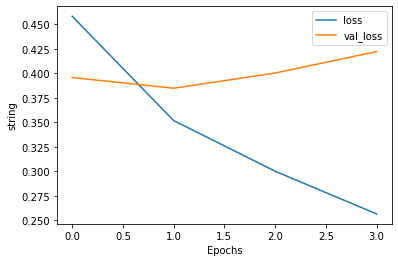

In [14]:
plot_graph(history, 'loss')

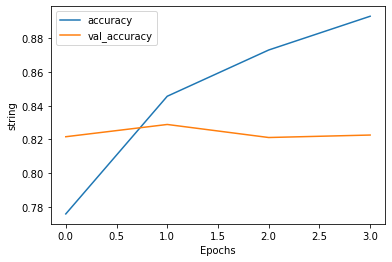

In [15]:
plot_graph(history, 'accuracy')

In [17]:
INPUT_TEST_DATA = 'nsmc_test_input.npy'
LABEL_TEST_DATA = 'nsmc_test_label.npy'
SAVE_FILE_NM = 'weights.h5'

test_input = np.load(open(DATA_IN_PATH + INPUT_TEST_DATA, 'rb'))
test_label_data = np.load(open(DATA_IN_PATH + LABEL_TEST_DATA, 'rb'))

In [18]:
model.load_weights(os.path.join(DATA_OUT_PATH, model_name, SAVE_FILE_NM))

In [19]:
model.evaluate(test_input, test_label_data)

1563/1563 [==============================] - 1s 928us/step - loss: 0.3875 - accuracy: 0.8256


[0.38746336102485657, 0.8256000280380249]